In [ ]:
import pandas as pd
import numpy as np
import Utils
import tensorflow as tf
import keras
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import Concatenate
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import to_categorical, plot_model

# import nltk
# nltk.download('stopwords')

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import re
import gc

import Utils.data_utils as data
import Utils.metric_utils as mtric
import getpass

In [2]:
#%time data_x, data_y = load_data('dataset/Raw/Train.tsv', [1, 3, 4], True, 1)
MAX_NB_WORDS = 30000
EMBEDDING_DIM = 200
#MAX_SEQUENCE_LENGTH = 300

path_train = 'dataset/Processed/Train_coma_blind_num.pickle'
path_test = 'dataset/Processed/Test_coma_blind_num.pickle'
path_w2v = 'W2V/wikipedia-pubmed-and-PMC-w2v.bin' # http://evexdb.org/pmresources/vec-space-models/

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
dataset = data.Dataset()

dataset.load_pickle(path_train, path_test, label_name='rating')
model = KeyedVectors.load_word2vec_format(path_w2v, binary=True)
MAX_SEQUENCE_LENGTH = dataset.text_len_distribution(col_name='review', plot=False)[0]

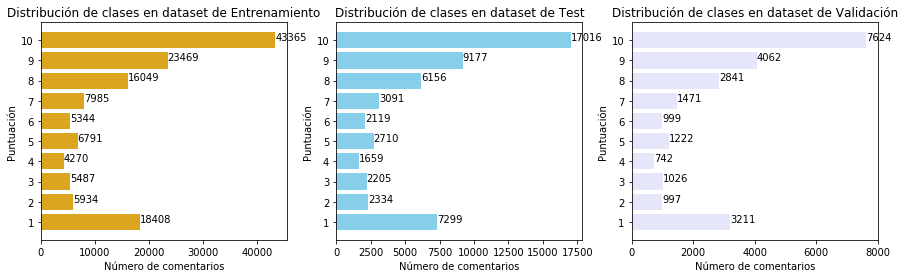

In [3]:
tokenizer.fit_on_texts([x for x in list(dataset.get_train_x().review)+list(dataset.get_test_x().review)])
dataset.make_dev_split(dev_split=0.15)
dataset.classes_distribution()

In [4]:
sequences_train = tokenizer.texts_to_sequences(dataset.get_train_x().review)
sequences_dev = tokenizer.texts_to_sequences(dataset.get_dev_x().review)
sequences_test = tokenizer.texts_to_sequences(dataset.get_test_x().review)

Xtrain = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xdev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xtest = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
ytrain = to_categorical(dataset.get_train_y()-dataset.get_train_y().min())
ydev = to_categorical(dataset.get_dev_y()-dataset.get_dev_y().min())
ytest = to_categorical(dataset.get_test_y()-dataset.get_test_y().min())

del sequences_dev, sequences_train, sequences_test
gc.collect()

8949

In [5]:
word_index = tokenizer.word_index
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype=np.float32)
count = 0
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in model:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]
        count = count+1
print (count," ",num_words)

24612   30000


In [6]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(df_train.label)), np.asarray(df_train.label))
# class_weight_dict = dict(enumerate(class_W))

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).argmax(axis=1)
        targ = self.validation_data[1].argmax(axis=1)
        #f1 = f1_score(targ, predict, average='micro')
        mtrcs = precision_recall_fscore_support(targ, predict, average='macro')
        print ("\nPrecision: "+str(mtrcs[0])+"\tRecall: "+str(mtrcs[1])+"\tF1: "+str(mtrcs[2]))
        if (self.f1s < mtrcs[2]):
            self.f1s = mtrcs[2]
            self.model.save('./model/Best_EMRS_model_f1_.hdf5')
            print("Modelo guardado\n")
        return
    
metrics = Metrics()

In [7]:
class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(dataset.get_train_y())), np.asarray(dataset.get_train_y()))
class_weight_dict = dict(enumerate(class_W))

In [8]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)
conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)

concat = Concatenate()([gmp_1,gmp_2,gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
mp_dense = Dense(128, activation='relu', name='mp_dense')(drop_out_2)
preds = Dense(10, activation='softmax', name='preds')(mp_dense)
Conv_model = Model(sequence_input, preds)

Conv_model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

callbacks_list = [metrics]

In [9]:
#200 epochs -> start at 13:35 - ends at XX:XX
Conv_model.fit(Xtrain, ytrain,
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=200,
      epochs=200,
      callbacks=callbacks_list,
      validation_data=(Xdev, ydev))

Train on 137102 samples, validate on 24195 samples
Epoch 1/200
137102/137102 [==============================] - 70s 512us/step - loss: 1.8690 - acc: 0.3543 - val_loss: 1.6737 - val_acc: 0.4110


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Precision: 0.191192823017333	Recall: 0.18836547643506188	F1: 0.14631920598962425
Modelo guardado

Epoch 2/200
137102/137102 [==============================] - 62s 453us/step - loss: 1.6876 - acc: 0.4050 - val_loss: 1.6135 - val_acc: 0.4272

Precision: 0.20869208212863066	Recall: 0.20504737887904434	F1: 0.17074282925191242
Modelo guardado

Epoch 3/200
137102/137102 [==============================] - 63s 457us/step - loss: 1.6379 - acc: 0.4186 - val_loss: 1.5894 - val_acc: 0.4348

Precision: 0.2230963142497065	Recall: 0.22456945394516342	F1: 0.18980433880258224
Modelo guardado

Epoch 4/200
137102/137102 [==============================] - 62s 456us/step - loss: 1.6088 - acc: 0.4239 - val_loss: 1.5622 - val_acc: 0.4417

Precision: 0.23674410938189033	Recall: 0.22728579615033473	F1: 0.19256511614424543
Modelo guardado

Epoch 5/200
137102/137102 [==============================] - 64s 466us/step - loss: 1.5933 - acc: 0.4279 - val_loss: 1.5468 - val_acc: 0.4412

Precision: 0.23032613184012737

137102/137102 [==============================] - 63s 459us/step - loss: 1.4629 - acc: 0.4641 - val_loss: 1.4672 - val_acc: 0.4638

Precision: 0.3010989910482361	Recall: 0.26483392146933926	F1: 0.2548823273535533
Modelo guardado

Epoch 38/200
137102/137102 [==============================] - 61s 448us/step - loss: 1.4645 - acc: 0.4637 - val_loss: 1.4668 - val_acc: 0.4666

Precision: 0.30580598454295294	Recall: 0.2595118841813087	F1: 0.24746039967542197
Epoch 39/200
137102/137102 [==============================] - 62s 453us/step - loss: 1.4638 - acc: 0.4645 - val_loss: 1.4647 - val_acc: 0.4677

Precision: 0.30733762509701423	Recall: 0.26381742895981564	F1: 0.25110841552124863
Epoch 40/200
137102/137102 [==============================] - 63s 461us/step - loss: 1.4634 - acc: 0.4650 - val_loss: 1.4665 - val_acc: 0.4651

Precision: 0.30931355109594577	Recall: 0.26274769122847486	F1: 0.25043490522818956
Epoch 41/200
137102/137102 [==============================] - 62s 455us/step - loss: 1.4623

137102/137102 [==============================] - 63s 460us/step - loss: 1.4381 - acc: 0.4736 - val_loss: 1.4518 - val_acc: 0.4705

Precision: 0.3179343818876007	Recall: 0.27849055401422124	F1: 0.27495414528157436
Modelo guardado

Epoch 74/200
137102/137102 [==============================] - 63s 463us/step - loss: 1.4359 - acc: 0.4730 - val_loss: 1.4542 - val_acc: 0.4683

Precision: 0.3085786326151707	Recall: 0.26593006667630703	F1: 0.25834362189565635
Epoch 75/200
137102/137102 [==============================] - 64s 464us/step - loss: 1.4356 - acc: 0.4731 - val_loss: 1.4513 - val_acc: 0.4703

Precision: 0.31646508944861695	Recall: 0.2751158093774848	F1: 0.2676356825323206
Epoch 76/200
137102/137102 [==============================] - 63s 462us/step - loss: 1.4365 - acc: 0.4733 - val_loss: 1.4523 - val_acc: 0.4675

Precision: 0.3076586863304409	Recall: 0.27095048628136403	F1: 0.2616581944660824
Epoch 77/200
137102/137102 [==============================] - 63s 462us/step - loss: 1.4356 - 

137102/137102 [==============================] - 64s 468us/step - loss: 1.4166 - acc: 0.4807 - val_loss: 1.4413 - val_acc: 0.4701

Precision: 0.3346246019247051	Recall: 0.27651994156221915	F1: 0.26596113464637916
Epoch 146/200
137102/137102 [==============================] - 63s 458us/step - loss: 1.4160 - acc: 0.4803 - val_loss: 1.4418 - val_acc: 0.4714

Precision: 0.3218984294028978	Recall: 0.2763925039621523	F1: 0.2708710440133236
Epoch 147/200
137102/137102 [==============================] - 64s 466us/step - loss: 1.4155 - acc: 0.4807 - val_loss: 1.4406 - val_acc: 0.4695

Precision: 0.32499481715490375	Recall: 0.2787344370122793	F1: 0.2742118383372038
Epoch 148/200
137102/137102 [==============================] - 63s 460us/step - loss: 1.4150 - acc: 0.4790 - val_loss: 1.4401 - val_acc: 0.4706

Precision: 0.32256971296859804	Recall: 0.2802100969056571	F1: 0.2759642815734387
Epoch 149/200
137102/137102 [==============================] - 63s 456us/step - loss: 1.4119 - acc: 0.4812 - v

In [10]:
plot_model(Conv_model,to_file='SEPLN.png',show_shapes=False)

In [11]:
# , custom_objects={'precision': mtric.precision, 'recall':mtric.recall, 'fmeasure':mtric.fmeasure}
Best_model = load_model('./model/Best_EMRS_model_f1_.hdf5')
# Conv_model = load_model('./model/064microf1_058macrof1_200epoch64filtros.hdf5')

In [12]:
# result = Best_model.predict(Xtest).argmax(axis=1)
result = Conv_model.predict(Xtest).argmax(axis=-1)
y_test = ytest.argmax(axis=1)
print(classification_report(y_test, result, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

              precision    recall  f1-score   support

           0     0.5339    0.8223    0.6474      7299
           1     0.2690    0.1195    0.1655      2334
           2     0.2592    0.1247    0.1684      2205
           3     0.2416    0.0820    0.1224      1659
           4     0.2473    0.1524    0.1886      2710
           5     0.2047    0.0897    0.1247      2119
           6     0.2625    0.0984    0.1431      3091
           7     0.2815    0.2695    0.2754      6156
           8     0.3737    0.2528    0.3016      9177
           9     0.5816    0.8205    0.6807     17016

   micro avg     0.4750    0.4750    0.4750     53766
   macro avg     0.3255    0.2832    0.2818     53766
weighted avg     0.4180    0.4750    0.4268     53766



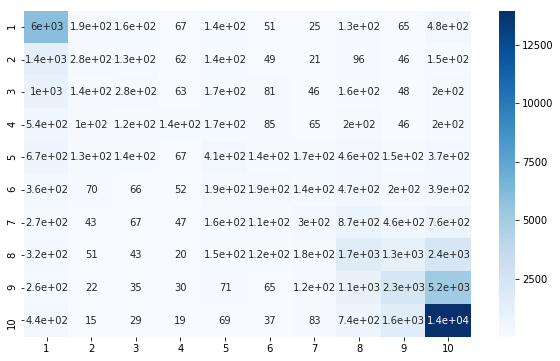

In [13]:
data.matrix_printer(confusion_matrix(y_test, result), [1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]).show()

In [14]:
print(confusion_matrix(y_test, result))

[[ 6002   190   157    67   139    51    25   127    65   476]
 [ 1358   279   133    62   142    49    21    96    46   148]
 [ 1028   136   275    63   169    81    46   161    48   198]
 [  541   102   115   136   172    85    65   202    46   195]
 [  667   129   141    67   413   139   171   463   152   368]
 [  355    70    66    52   187   190   144   474   195   386]
 [  267    43    67    47   162   106   304   871   463   761]
 [  323    51    43    20   146   125   179  1659  1254  2356]
 [  257    22    35    30    71    65   120  1102  2320  5155]
 [  444    15    29    19    69    37    83   739  1619 13962]]


In [15]:
del Conv_model
gc.collect()

0

In [15]:
Conv_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2006)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2006, 200)    6000000     input_1[0][0]                    
__________________________________________________________________________________________________
drop_out_1 (Dropout)            (None, 2006, 200)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 2005, 64)     25664       drop_out_1[0][0]                 
__________________________________________________________________________________________________
conv_2 (Co